## 1 Document Clustering

Solve a document clustering problem using unsupervised learning algorithms (i.e., soft and hard Expectation Maximization) for document clustering.

### I Derive Expectation and Maximization steps of the hard-EM algorithm for Document Clustering

**Document clustering** is a form of unsupervised machine learning that aims to partition documents $d_n$ into clusters $k_n$ according to shared attributes, such as word frequencies. In unsupervised learning we do not know the data labels, so the unknown (latent) document groupings are labelled $z_n$.

We use the **Gaussian Mixture model (GMM)**, a form of probabilistic generative model which describes each cluster as a separate Guassian distribution, to predict the conditional probabilties of each data point belonging to a cluster.

The parameters used to describe each Guassian distribution are the **mean $\mu$, covariance $\Sigma$** and **mixing probability $\varphi$**, collectively denoted by $\theta≔φ,μ_1,Σ_1,…,μ_K,Σ_K$. These are assembled in Bayes formula to define the following prediction rule which describes the probability of belonging to a cluster $k$ given a data point $x_n$ (or the responsibility ($r_{nk}$) that cluster k takes for explaining the observation $x_n$):
$$r_{nk} = p(z_n=k|x_n)=\frac{\varphi N(x_n|\mu_k,\Sigma_k)}{\Sigma_j \varphi_j N(x_n|\mu_j,\Sigma_j)}$$


Where $j$ is the index across all possible clusters.

To find model parameters $\theta$ we can use **Expectation Maximisation (EM)**, which attempts to maximise the log-likelihood to find the optimal parameter values.

$\theta$ values are initialised to random values, and then the EM algorithm proceeds in a two step process:

**The E step**: In hard-EM we use the current $\theta$ values and calculate posterior distributions $p(Z|X,\theta)$ in order to allocate data points to clusters with the highest probabiltiy.

Using this assignment, clusters are updated via: $Z^* \leftarrow argmax_z p(Z|X, \theta^{old})$.

The expected value of the log-likelihood $Q$ is then calculated as the sum of log-likelihoods of each data point under it's cluster allocation: 

$$Q(\theta, \theta^{old}):=\Sigma_n log (x_n, Z^*_n|\theta^{old}) := \Sigma_z ln p(\varphi_{k_n}N(x_n|\mu_{kn},\Sigma_{k_n})) = L(\theta^{old})$$


**The M step**: In the M step the Q function is maximised by taking the partial derivative with respect to each parameter and setting to 0. The resulting equations (and parameter updates) are as follows:

mean: $\mu_k = \frac{\sum_{n=1}^{N} \gamma(Z_{nk}) x_n}{N_k}$

covariance: $\Sigma_k = \frac{\sum_{n=1}^{N} \gamma(Z_{nk}) (x_n - \mu_k)(x_n - \mu_k)^T}{N_k}$

mixing coefficient: $\varphi_k = \frac{N_k}{N}$ (noting $\Sigma\varphi_k = 1$)

where:<br>
$\gamma(Z_{nk}) : = p(Z_{nk} = 1 | x_n, \theta^{old})$, $N_k := \Sigma^N_{n=1} \gamma(Z_{nk})$:<br><br>

Finally $\theta^{(old)}$ is set to $\theta$ and the process repeats


### II Load Task2A.txt file 

In [590]:
#import libraries
from scipy.stats import multivariate_normal
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [591]:
#load and assign Task2A.txt to variable
with open('Task2A.txt', 'r') as file:
    text = file.readlines()

In [592]:
#check text length
len(text), len(text[0])

(2373, 10864)

In [593]:
#split text into labels and articles
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]
articles[0][0:10]

'ripem freq'

In [594]:
#give data labels integer codes for plotting
df = pd.DataFrame(zip(labels, articles), columns=['label', 'article'])
df['code']= pd.Categorical(df['label']).codes

np.unique(df.code)

array([0, 1, 2, 3], dtype=int8)

In [595]:
#create TF-IDF features which consider frequency of words in a document and across all documents
tfidf = TfidfVectorizer(lowercase=True, stop_words='english', min_df=5, norm='l2')
features = tfidf.fit_transform(raw_documents=np.asarray(articles))
features.shape

(2373, 8094)

### III Implement the hard-EM (derived above) and soft-EM 

In [596]:
class HardGMM: 
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'HardGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0]
        ## initialization:
        self.Varphi_hat_ = np.array([1/self.K] * self.K) # assume all clusters have the same prob (we will update this later on)
        self.Nk_hat_ = self.Varphi_hat_ * N                                       
        self.Mu_hat_ = X[np.random.choice(N, size=self.K, replace=False)] # randomly  choose K samples as cluster means (any better idea?)
        self.Sigma_hat_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)]) # create identity covariance matrices as initialization
        r = np.zeros((N,self.K)) # empty posterior matrix (the membership estimates will be stored here)                

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            # E step:
            for k in range(self.K):

                ## calculate the posterior based on the estimated means,covariance and cluster size:
                r[:,k] = self.Varphi_hat_[k] * multivariate_normal.pdf(X, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])

            #find argmax
            max_indicator = lambda x:  np.array([1 if i== x.argmax() else 0 for i in range(len(x))])
            z_n_hat = np.array(list(map(max_indicator, r)), dtype='float32')
            r = z_n_hat
            
            # M step (note that we use the vectorised notation directly which is much better and faster than using a for loop):
            self.Nk_hat_ = r.sum(axis=0)
            self.Varphi_hat_ = self.Nk_hat_/N
            self.Mu_hat_ = (r.T @ X)/ self.Nk_hat_.reshape((-1,1))
            # only Sigma must be calculated in a loop because it involves element wise multiplication with r
            for k in range(K):
                r_k = r[:,k,None]   #this None is to reshape the array to a singleton
                # apply formula
                self.Sigma_hat_[k] = 1/self.Nk_hat_[k] * ( (X - self.Mu_hat_[k]).T @ (r_k * (X - self.Mu_hat_[k])) )

            # increase iteration counter
            tau +=1

            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        if verbose: print(f'Converged in {tau} iterations')

        return self
        
        
    def predict_proba(self, x):
        N = x.shape[0]
        r = np.zeros((N,self.K))
        for k in range(self.K):
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            r[:,k] = self.Varphi_hat_[k] * multivariate_normal.pdf(x, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])
        r /= r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
        
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds


In [597]:
from scipy.stats import multivariate_normal

class SoftGMM: 
    def __init__(self, K, tau_max=200, epsilon=0.01, random_state=None):
        self.K = K               # number of GMM clusters
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon  # minimum acceptable error rate
        self.random_state = random_state
        np.random.seed(self.random_state)

    def get_params(self, deep=False):
        return {'K': self.K,
         'tau_max': self.tau_max,
         'epsilon': self.epsilon,
         'random_state': self.random_state}
    
    def __str__(self):
        params = self.get_params()
        return 'SoftGMM({0})'.format(','.join(['='.join([key, str(params[key])]) for key in params.keys()]))

    def __repr__(self):
        return self.__str__()
                
    def fit(self, X, verbose=False):
        N = X.shape[0]
        ## initialization:
        self.Psi_hat_ = np.array([1/self.K] * self.K)                         # assume all clusters have the same prob (we will update this later on)
        self.Nk_hat_ = self.Psi_hat_ * N                                       
        self.Mu_hat_ = X[np.random.choice(N, size=self.K, replace=False)]   # randomly  choose K samples as cluster means (any better idea?)
        self.Sigma_hat_ = np.array([np.eye(X.shape[1]) for _ in range(self.K)])     # create identity covariance matrices as initialization
        r = np.zeros((N,self.K))                                     # empty posterior matrix (the membership estimates will be stored here)                
        
        self.Mu_hat_historic_ = np.zeros(shape=(list(self.Mu_hat_.shape) + [self.tau_max]))
        self.r_historic_ = np.zeros(shape=(N, self.K, self.tau_max))

        terminate= False
        tau = 0
        # fitting loop - we iteratively take E and M steps until the termination criterion is met.
        Mu_hat_old = self.Mu_hat_ # Mu_hat_old is used to store the last iteration value for mu_hat
        while (not terminate):
            if verbose: print('iteration {0}'.format(tau))
            
            # E step:
            for k in range(self.K):
                ## calculate the posterior based on the estimated means,covariance and cluster size:
                r[:,k] = self.Psi_hat_[k] * multivariate_normal.pdf(X, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k], allow_singular=True) + 1e-10
            r /= r.sum(axis=1, keepdims=True) # normalization (to make sure sum(r)=1)
            self.r_historic_[:, :, tau] = r
            
            # M step (note that we use the vectorised notation directly which is much better and faster than using a for loop):
            self.Nk_hat_ = r.sum(axis=0)
            self.Psi_hat_ = self.Nk_hat_/N
            self.Mu_hat_ = (r.T @ X)/ self.Nk_hat_.reshape((-1,1))
            self.Mu_hat_historic_[:, :, tau] = self.Mu_hat_
            # only Sigma must be calculated in a loop because it involves element wise multiplication with r
            for k in range(K):
                r_k = r[:,k,None]   #this None is to reshape the array to a singleton
                # apply formula
                self.Sigma_hat_[k] = 1/self.Nk_hat_[k] * ( (X - self.Mu_hat_[k]).T @ (r_k * (X - self.Mu_hat_[k])) )

            # increase iteration counter
            tau +=1

            # check termination condition
            terminate = ((tau == self.tau_max) or np.allclose(self.Mu_hat_, Mu_hat_old, rtol= self.epsilon))
            # record the means (neccessary for checking the termination criteria)
            Mu_hat_old = self.Mu_hat_

        self.Mu_hat_historic_ = self.Mu_hat_historic_[:, :, :tau]
        self.r_historic_ = self.r_historic_[:, :, :tau]

        if verbose: print(f'Converged in {tau} iterations')

        return self
        
        
    def predict_proba(self, x):
        N = x.shape[0]
        r = np.zeros((N,self.K))
        for k in range(self.K):
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            r[:,k] = self.Psi_hat_[k] * multivariate_normal.pdf(x, mean=self.Mu_hat_[k], cov=self.Sigma_hat_[k])
        r /= r.sum(axis=1,keepdims=True) # normalization (to make sure sum(r)=1)
        
        return r

    def predict(self, x):
        probs = self.predict_proba(x)
        preds = np.argmax(probs, axis=1)
        return preds

### IV Set the number of clusters K=4, and run both the soft-EM and hard-EM algorithms on the provided data.

In [615]:
from sklearn.decomposition import PCA

#perform PCA to reduce dimensionality
#performed BEFORE passing to GMM's as encountered errors passing without reduction

pca = PCA(n_components=2)
x = pca.fit_transform(features.toarray())

In [612]:
soft_gmm = SoftGMM(K=4, random_state=0).fit(x, verbose=True)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
Converged in 20 iterations


In [613]:
hard_gmm = HardGMM(K=4).fit(x, verbose=True)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
Converged in 9 iterations


### V Plot the obtained clusters with different colors where x and y axes are the first two principal components

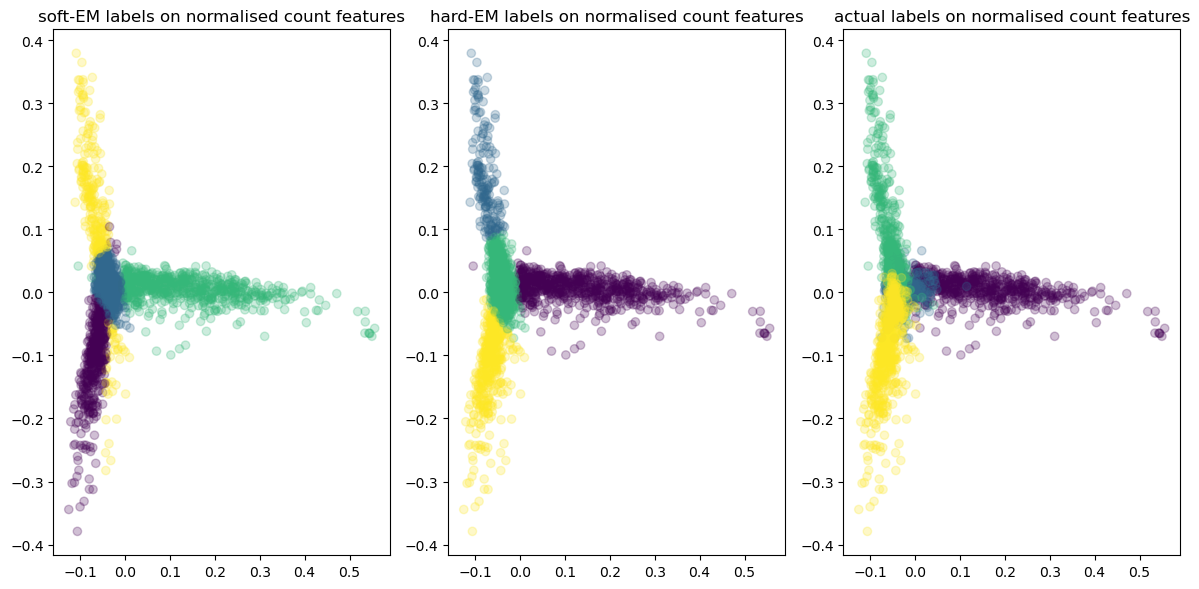

In [614]:
## soft-EM plot
_, axs = plt.subplots(1, 3, figsize=(12, 6), tight_layout=True)
axs[0].scatter(x[:,0], x[:,1], c=soft_gmm.predict(x), alpha=0.25)
axs[0].set_title('soft-EM labels on normalised count features')

## hard_EM plot
axs[1].scatter(x[:,0], x[:,1], c=hard_gmm.predict(x), alpha=0.25)
axs[1].set_title('hard-EM labels on normalised count features')

## actual plot
axs[2].scatter(x[:,0], x[:,1], c=df.code, alpha=0.25)
axs[2].set_title('actual labels on normalised count features')
plt.show()

#### Why the hard and soft-EM are different

Soft-EM (SEM) assigns probabilties of each data point belonging to each cluster, resulting in a gradient of assignments. In contrast Hard-EM (HEM) assigns each data point to one particular cluster based on the highest probability values obtained. This can be seen in the plots where SEM borders appear more nuanced/soft while HEM borders are more defined/hard. Comparing to the actual labels, it appears both algorithms are reasonably accurate at predicting the cluster assignments and comparable in performance.